## Setting up Basecamp

In [1]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
! pip install pgeocode

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     | 92.8 MB 1.1 MB/s
ERROR: Operation cancelled by user
     |████████████████████████████████| 2.8 MB 4.3 MB/s 
ERROR: Operation cancelled by user


## Import stuff

In [ ]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
import pgeocode
import numpy as np

In [ ]:
df = pd.read_excel("/content/drive/My Drive/stocks.xlsx",index_col = 0)

Index(['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city',
       'phone', 'state', 'country', 'companyOfficers', 'website',
       ...
       'earningsQuarterlyGrowth', 'dateShortInterest', 'pegRatio',
       'lastCapGain', 'shortPercentOfFloat', 'sharesShortPriorMonth',
       'category', 'fiveYearAverageReturn', 'regularMarketPrice', 'logo_url'],
      dtype='object', length=122)

## Convert zip codes to coordinates

In [ ]:
nomi = pgeocode.Nominatim('us')
df_locs = nomi.query_postal_code(df['zip'].values)
df_locs = df_locs[['postal_code','latitude','longitude']]

df_locs.set_index(df.index,inplace=True)
df_locs['marketCap'] = df['marketCap']/1e9 #market cap in billions
df_locs[['trailingPE','forwardPE']] = df[['trailingPE','forwardPE']]
df_locs = df_locs[df_locs['latitude'].notna()]
# df.columns[df.columns.str.lower().str.contains('pe')] : find all columns with PE in it

## Creating map plots

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


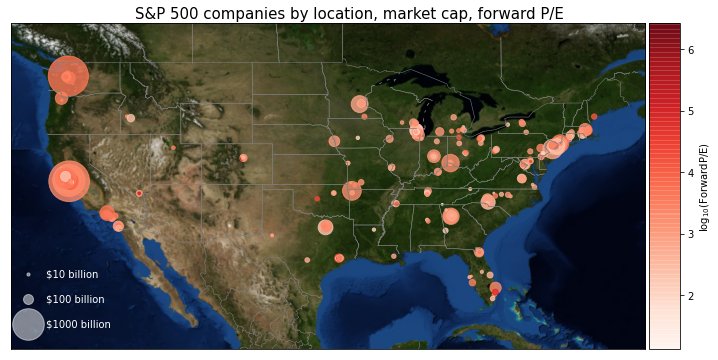

In [ ]:
fig = plt.figure(figsize=(12, 8))
m = Basemap(projection='cyl', resolution='h', 
            llcrnrlon = df_locs['longitude'].min()-5,llcrnrlat=df_locs['latitude'].min()-5,
            urcrnrlon=df_locs['longitude'].max()+5,urcrnrlat=df_locs['latitude'].max()+5,
                        lat_0=(df_locs['latitude'].max()+df_locs['latitude'].min())/2, 
            lon_0=(df_locs['longitude'].max()+df_locs['longitude'].min())/2+10,)
m.bluemarble()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Extract the data we're interested in
lat = df_locs['latitude'].values
lon = df_locs['longitude'].values
marketCap = df_locs['marketCap'].values
forwardPE = df_locs['forwardPE'].values

# 2. scatter loc data, with color reflecting p/e
# and size reflecting market cap
m.scatter(lon, lat, latlon=True,
          s=(marketCap), c=np.log(forwardPE),
          cmap='Reds', alpha=0.8)

# 3. create colorbar and legend
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(label=r'$\log_{10}({\rm Forward P/E})$',cax=cax,pad = 0.05)

# make legend with dummy points
for a in [10, 100, 1000]:
    plt.scatter([], [], c='white', alpha=0.5, s=a,
                label='$' + str(a) + ' billion')
l = plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1.5, loc= (-20, 0.05));
for text in l.get_texts():
  text.set_color("white")

plt.text(-85,6.5,'S&P 500 companies by location, market cap, forward P/E', size = 15)

plt.savefig('/content/drive/My Drive/sp500_companies.jpeg',format = 'jpeg')